In [1]:
#Script to compare epitope length in datasets
#@Author: Henriette Capel
#@Date: 15-03-2022

In [1]:
#Import modules
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from statsmodels.stats.weightstats import ztest as ztest
import pandas as pd
import ast
#from ABDB import database as db
import dabest

#%load_ext nb_black

In [2]:
plt.rcParams['figure.dpi'] = 1200

In [3]:
#Functions
def read_dataset(filename_ds):
    
    df = pd.read_csv(filename_ds, converters={i: str for i in range(100)})
    
    for colname in df.columns.values.tolist():
        try:
            df[colname] = [ast.literal_eval(d) for d in df[colname]]
        except:
            pass

    return df


def determine_interaction_lengths(df):
    #Determines the length of the epitope and the paratope. 
    epitope_length_list = []
    paratope_length_list = []
    paratope_heavy_length_list = []
    
    for index, row in df.iterrows():
        epi_dict = row['epitope_MWV_dict']
        para_dict = row['paratope_MWV_dict']
        ab_chain = row['antibody_chain']
        
        is_full_length = (len(ab_chain)== 2)
        if is_full_length:
            #Note epitope length for full length can contain same residue in heavy and light chain. Should count as one. 
            epi_length = len(epi_dict[ab_chain]) #length of the nested dictionary with key "ab_chain"
            para_length = sum(len(v) for v in para_dict.values()) #Length of the two nested dictionaries (L and H) combined
            para_heavy_length = len(para_dict[ab_chain[0]])
            paratope_heavy_length_list.append(para_heavy_length)
        else:
            epi_length = len(epi_dict)
            para_length = len(para_dict)
            
        epitope_length_list.append(epi_length)
        paratope_length_list.append(para_length)
        
    df['epitope_length'] = epitope_length_list
    df['paratope_length'] = paratope_length_list
    if is_full_length:
        df['paratope_heavy_length'] = paratope_heavy_length_list
    
    return df
        

def perform_bootstrap(n_sample, interaction_sizes):
    df = pd.DataFrame([np.random.choice(interaction_sizes[k],n_sample,replace=False) for k in interaction_sizes]).T
    df.columns = [k for k in interaction_sizes]
    x = dabest.load(df, idx=(list(interaction_sizes.keys())[0],list(interaction_sizes.keys())[1]))
    print(x.mean_diff)

def plot_interaction_length(list_1, list_2, type_interaction, ab_type1, ab_type2, color1, color2, bins =20):
    #Plot the difference between the epitope/paratope length
    # mean_1 = round(np.mean(np.array(list_1)), 2)
    # median_1 = round(np.median(np.array(list_1)), 2)
    # std_1 = round(np.std(np.array(list_1)), 2)
    
    
    # mean_2 = round(np.mean(np.array(list_2)), 2)
    # median_2 = round(np.median(np.array(list_2)), 2)
    # std_2 = round(np.std(np.array(list_2)), 2)
    
    # plt.hist(list_1, alpha=0.5, bins = bins, label=f"{ab_type1} \n ({mean_1}, {median_1}, {std_1})", density=True, stacked = True, color = color1)
    # plt.hist(list_2, alpha=0.5, bins = bins, label=f"{ab_type2} \n ({mean_2}, {median_2}, {std_2})", density=True, stacked = True, color = color2)
    plt.hist(list_1, bins = bins, label=ab_type1, density=True, stacked = True, color = color1, alpha=0.7)
    plt.hist(list_2, bins = bins, label=ab_type2, density=True, stacked = True, color = color2, alpha=0.7)
    plt.xlabel(f"{type_interaction} size", fontsize = 12)
    plt.ylabel("Normalised frequency", fontsize = 12)
    plt.legend(fontsize = 12)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.tight_layout()
    # plt.show()
    plt.savefig(f'{type_interaction}_arp_size.png', bbox_inches='tight')


In [4]:
#Single domain antibodies
ds_name_nb = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_nb_filtered.csv"
df_nb = read_dataset(ds_name_nb)
df_lengths_nb = determine_interaction_lengths(df_nb)

In [5]:
#Full length antibodies
ds_name_fv = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_fv_filtered.csv"
df_fv = read_dataset(ds_name_fv)
df_lengths_fv = determine_interaction_lengths(df_fv)

DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:18:38 2023.

The unpaired mean difference between sdab and flab is 0.64 [95%CI -0.307, 1.61].
The p-value of the two-sided permutation t-test is 0.187. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


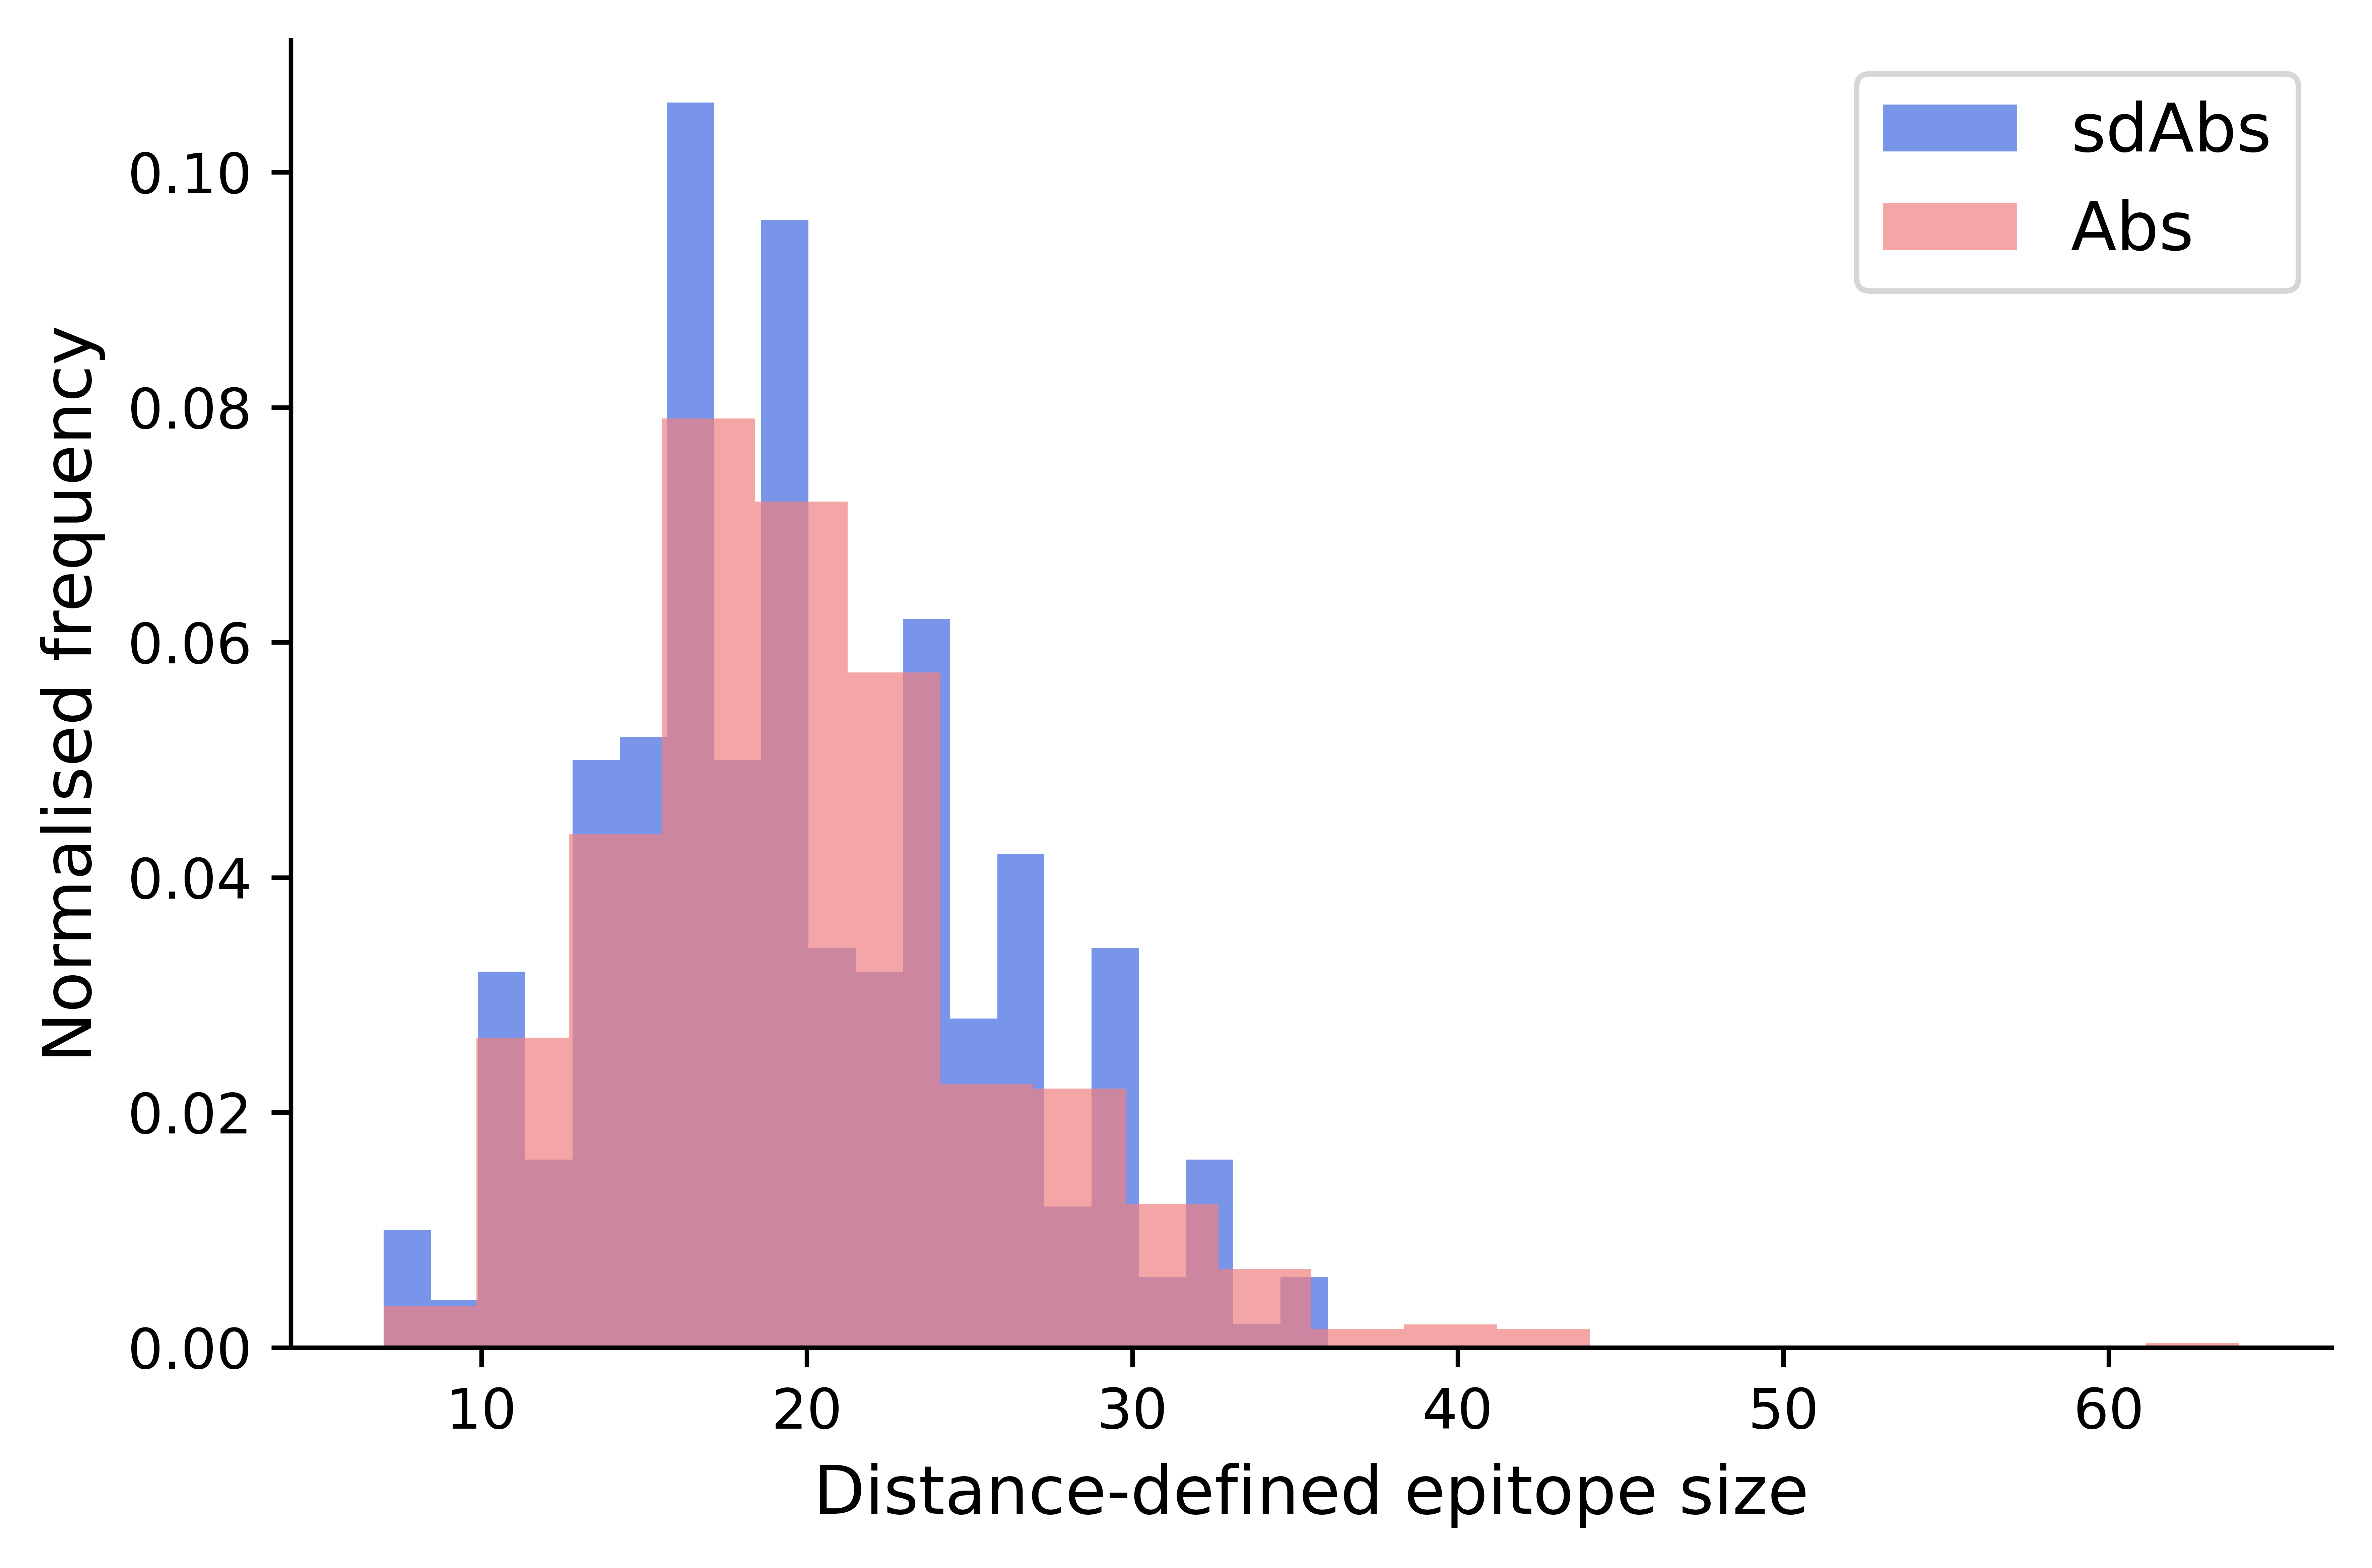

In [6]:
#Plot epitope length
plot_interaction_length(df_lengths_nb["epitope_length"], df_lengths_fv["epitope_length"], 'Distance-defined epitope', 'sdAbs', 'Abs', 'royalblue', 'lightcoral', bins=20)
ztest(df_lengths_nb["epitope_length"], df_lengths_fv["epitope_length"], value=0) 
perform_bootstrap(300, {'sdab': df_lengths_nb["epitope_length"], 'flab': df_lengths_fv["epitope_length"]})


DABEST v0.3.1
             
Good afternoon!
The current time is Wed Mar 29 17:14:38 2023.

The unpaired mean difference between sdab and flab_VH is -4.43 [95%CI -5.18, -3.7].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


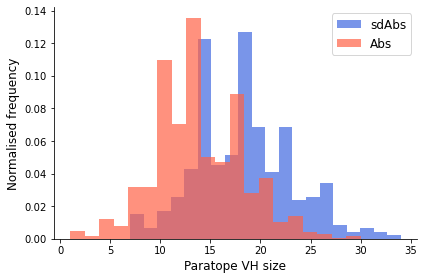

In [7]:
#Plot paratope (heavy chain length)
plot_interaction_length(df_lengths_nb["paratope_length"], df_lengths_fv["paratope_heavy_length"], 'Paratope VH', 'sdAbs', 'Abs', 'royalblue', 'tomato')
ztest(df_lengths_nb["paratope_length"].to_numpy(), df_lengths_fv["paratope_heavy_length"].to_numpy(), value=0) 
perform_bootstrap(300, {'sdab': df_lengths_nb["paratope_length"], 'flab_VH': df_lengths_fv["paratope_heavy_length"]})

DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:19:40 2023.

The unpaired mean difference between sdab and flab is 3.58 [95%CI 2.8, 4.43].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


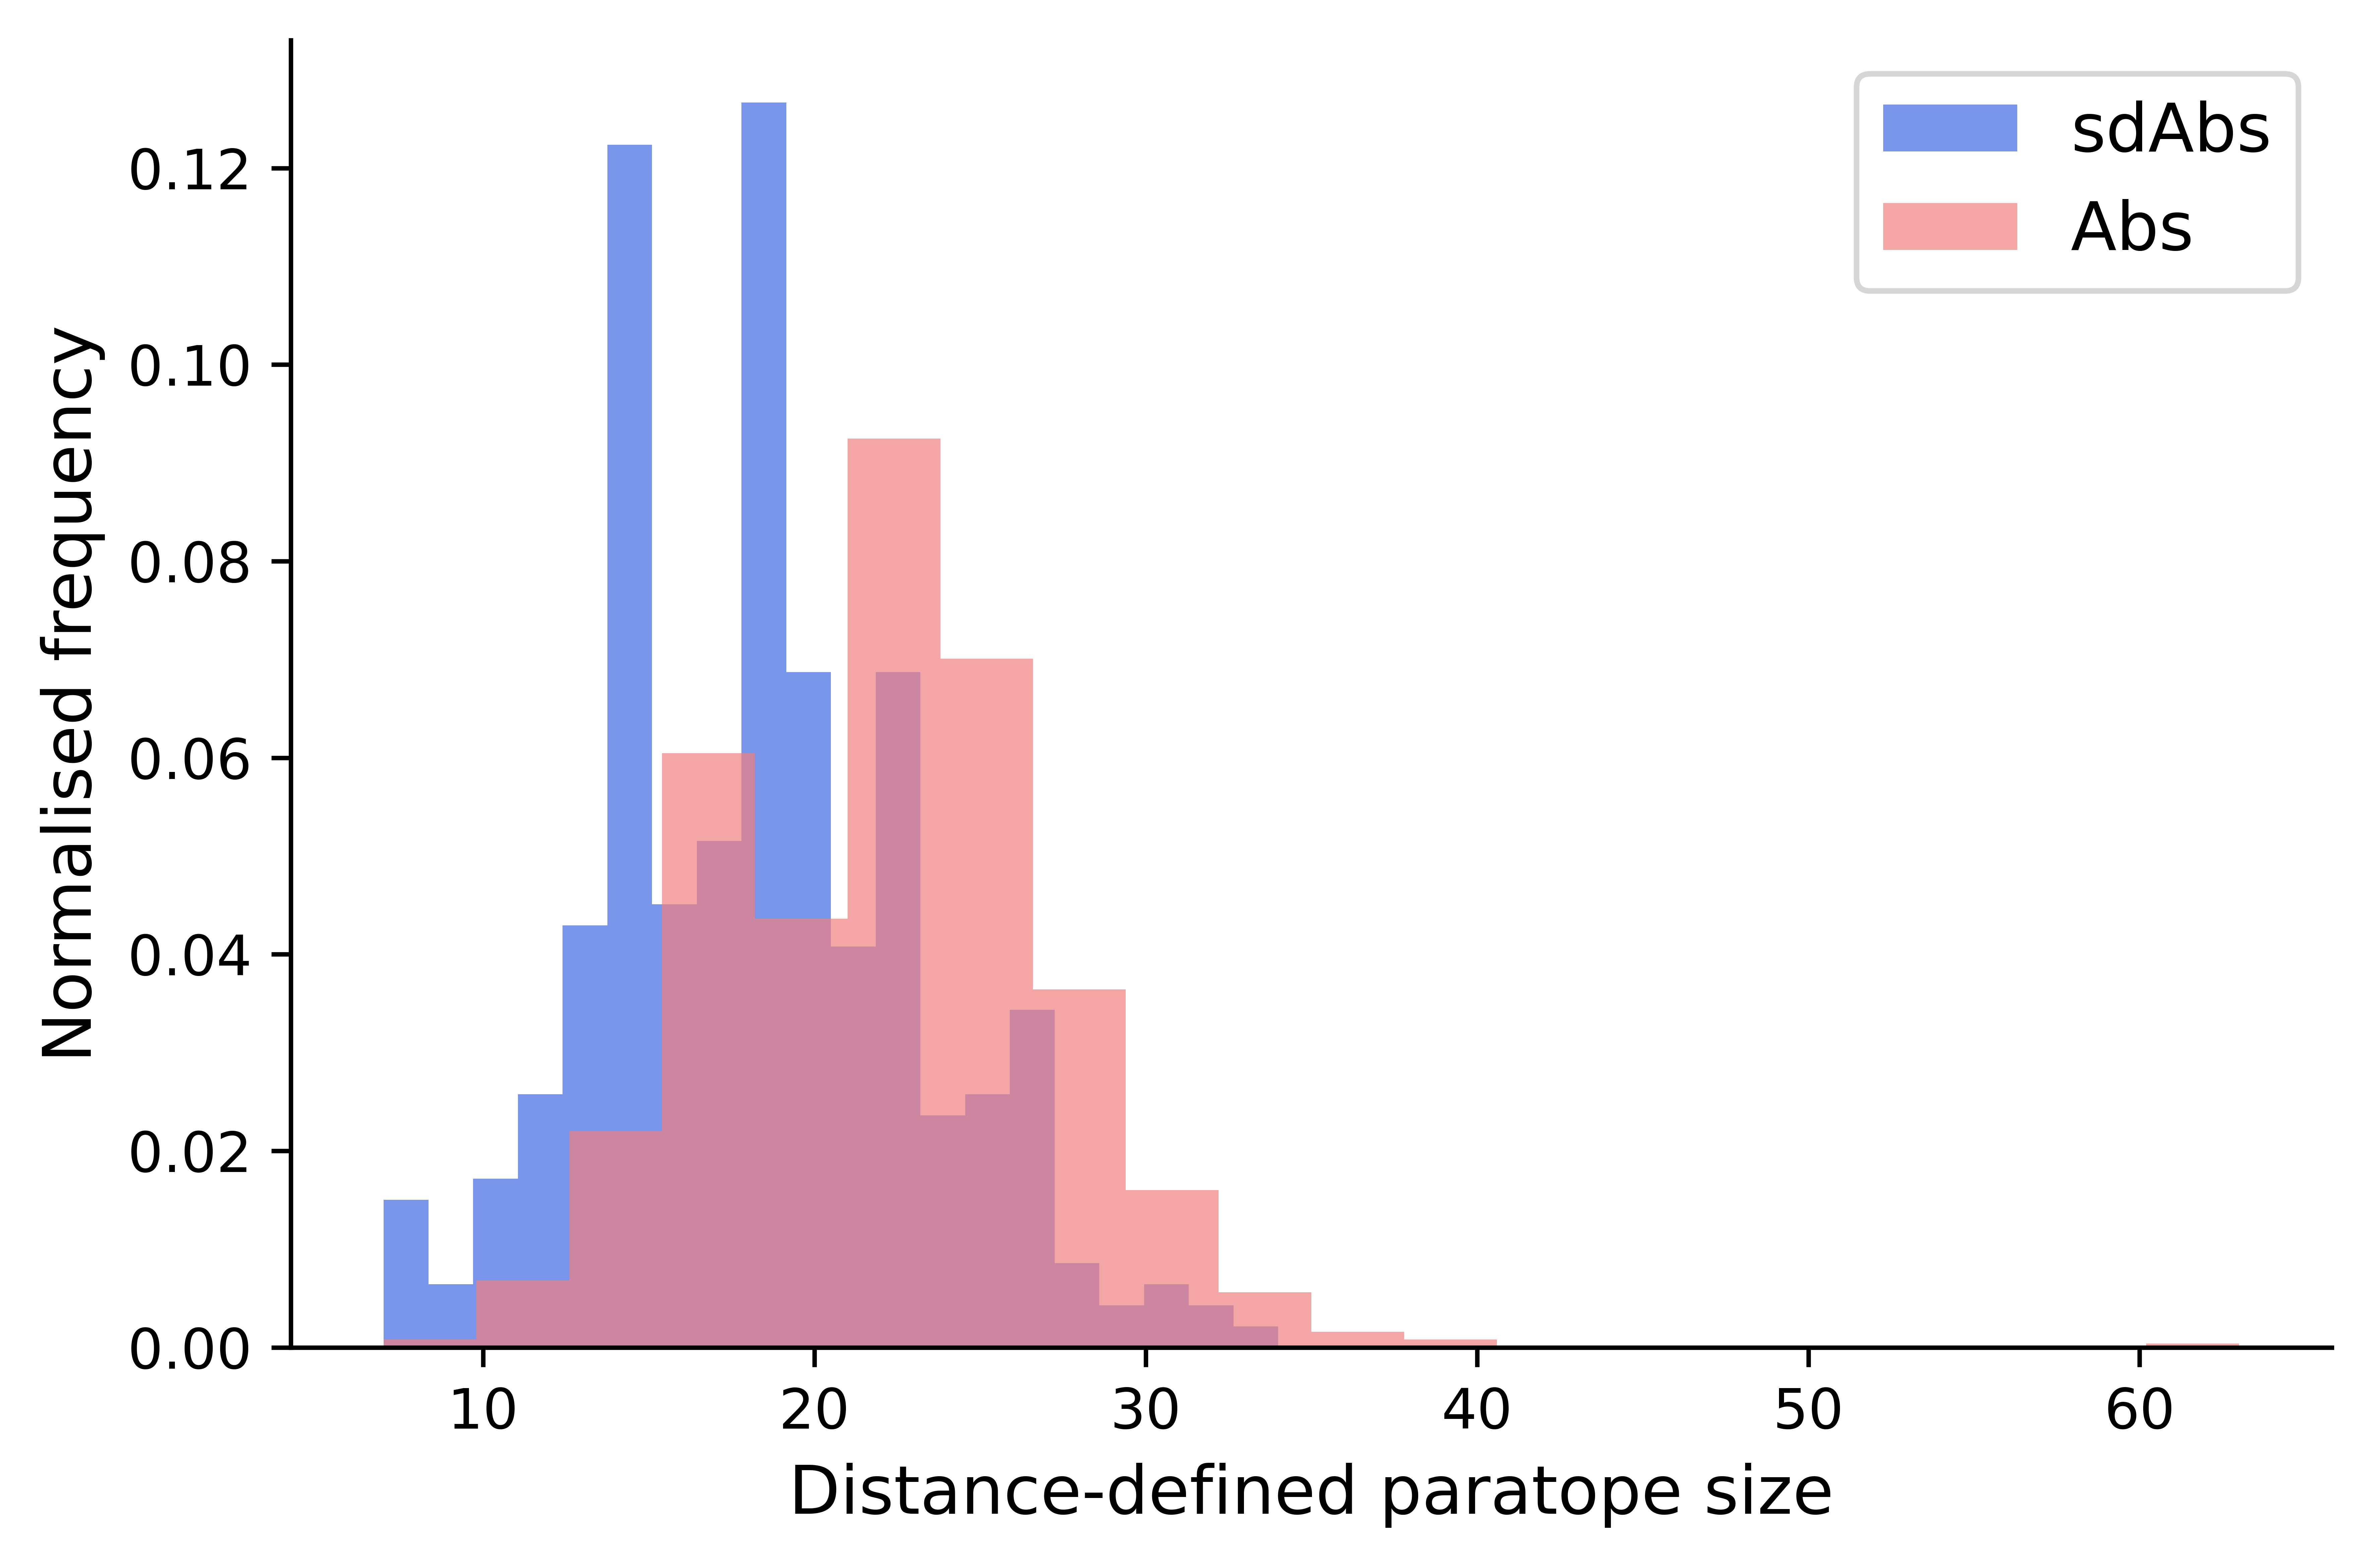

In [7]:
#Plot paratope length, for full length both heavy and light combined
plot_interaction_length(df_lengths_nb["paratope_length"], df_lengths_fv["paratope_length"], 'Distance-defined paratope', 'sdAbs', 'Abs', 'royalblue', 'lightcoral')
ztest(df_lengths_nb["paratope_length"].to_numpy(), df_lengths_fv["paratope_length"].to_numpy(), value=0) 
perform_bootstrap(300, {'sdab': df_lengths_nb["paratope_length"], 'flab': df_lengths_fv["paratope_length"]})


In [9]:
##### AFTER ARPEGGIO

In [9]:
#Single domain antibodies
ds_name_arp_int_nb = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_nb_arpeggio_interactions.csv"
df_arp_int_nb = read_dataset(ds_name_arp_int_nb)

df_lengths_arp_nb = determine_interaction_lengths(df_arp_int_nb)

In [10]:
#Full length antibodies
ds_name_arp_int_fv = "/Users/gemmagordon/Documents/OXFORD/ROTATION 2/henriette/vhh-vh-epitope-comparison/Dataset_fv_arpeggio_interactions.csv"
df_arp_int_fv = read_dataset(ds_name_arp_int_fv)

df_lengths_arp_fv = determine_interaction_lengths(df_arp_int_fv)

DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:20:17 2023.

The unpaired mean difference between sdab and flab is 0.223 [95%CI -0.457, 0.85].
The p-value of the two-sided permutation t-test is 0.506. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


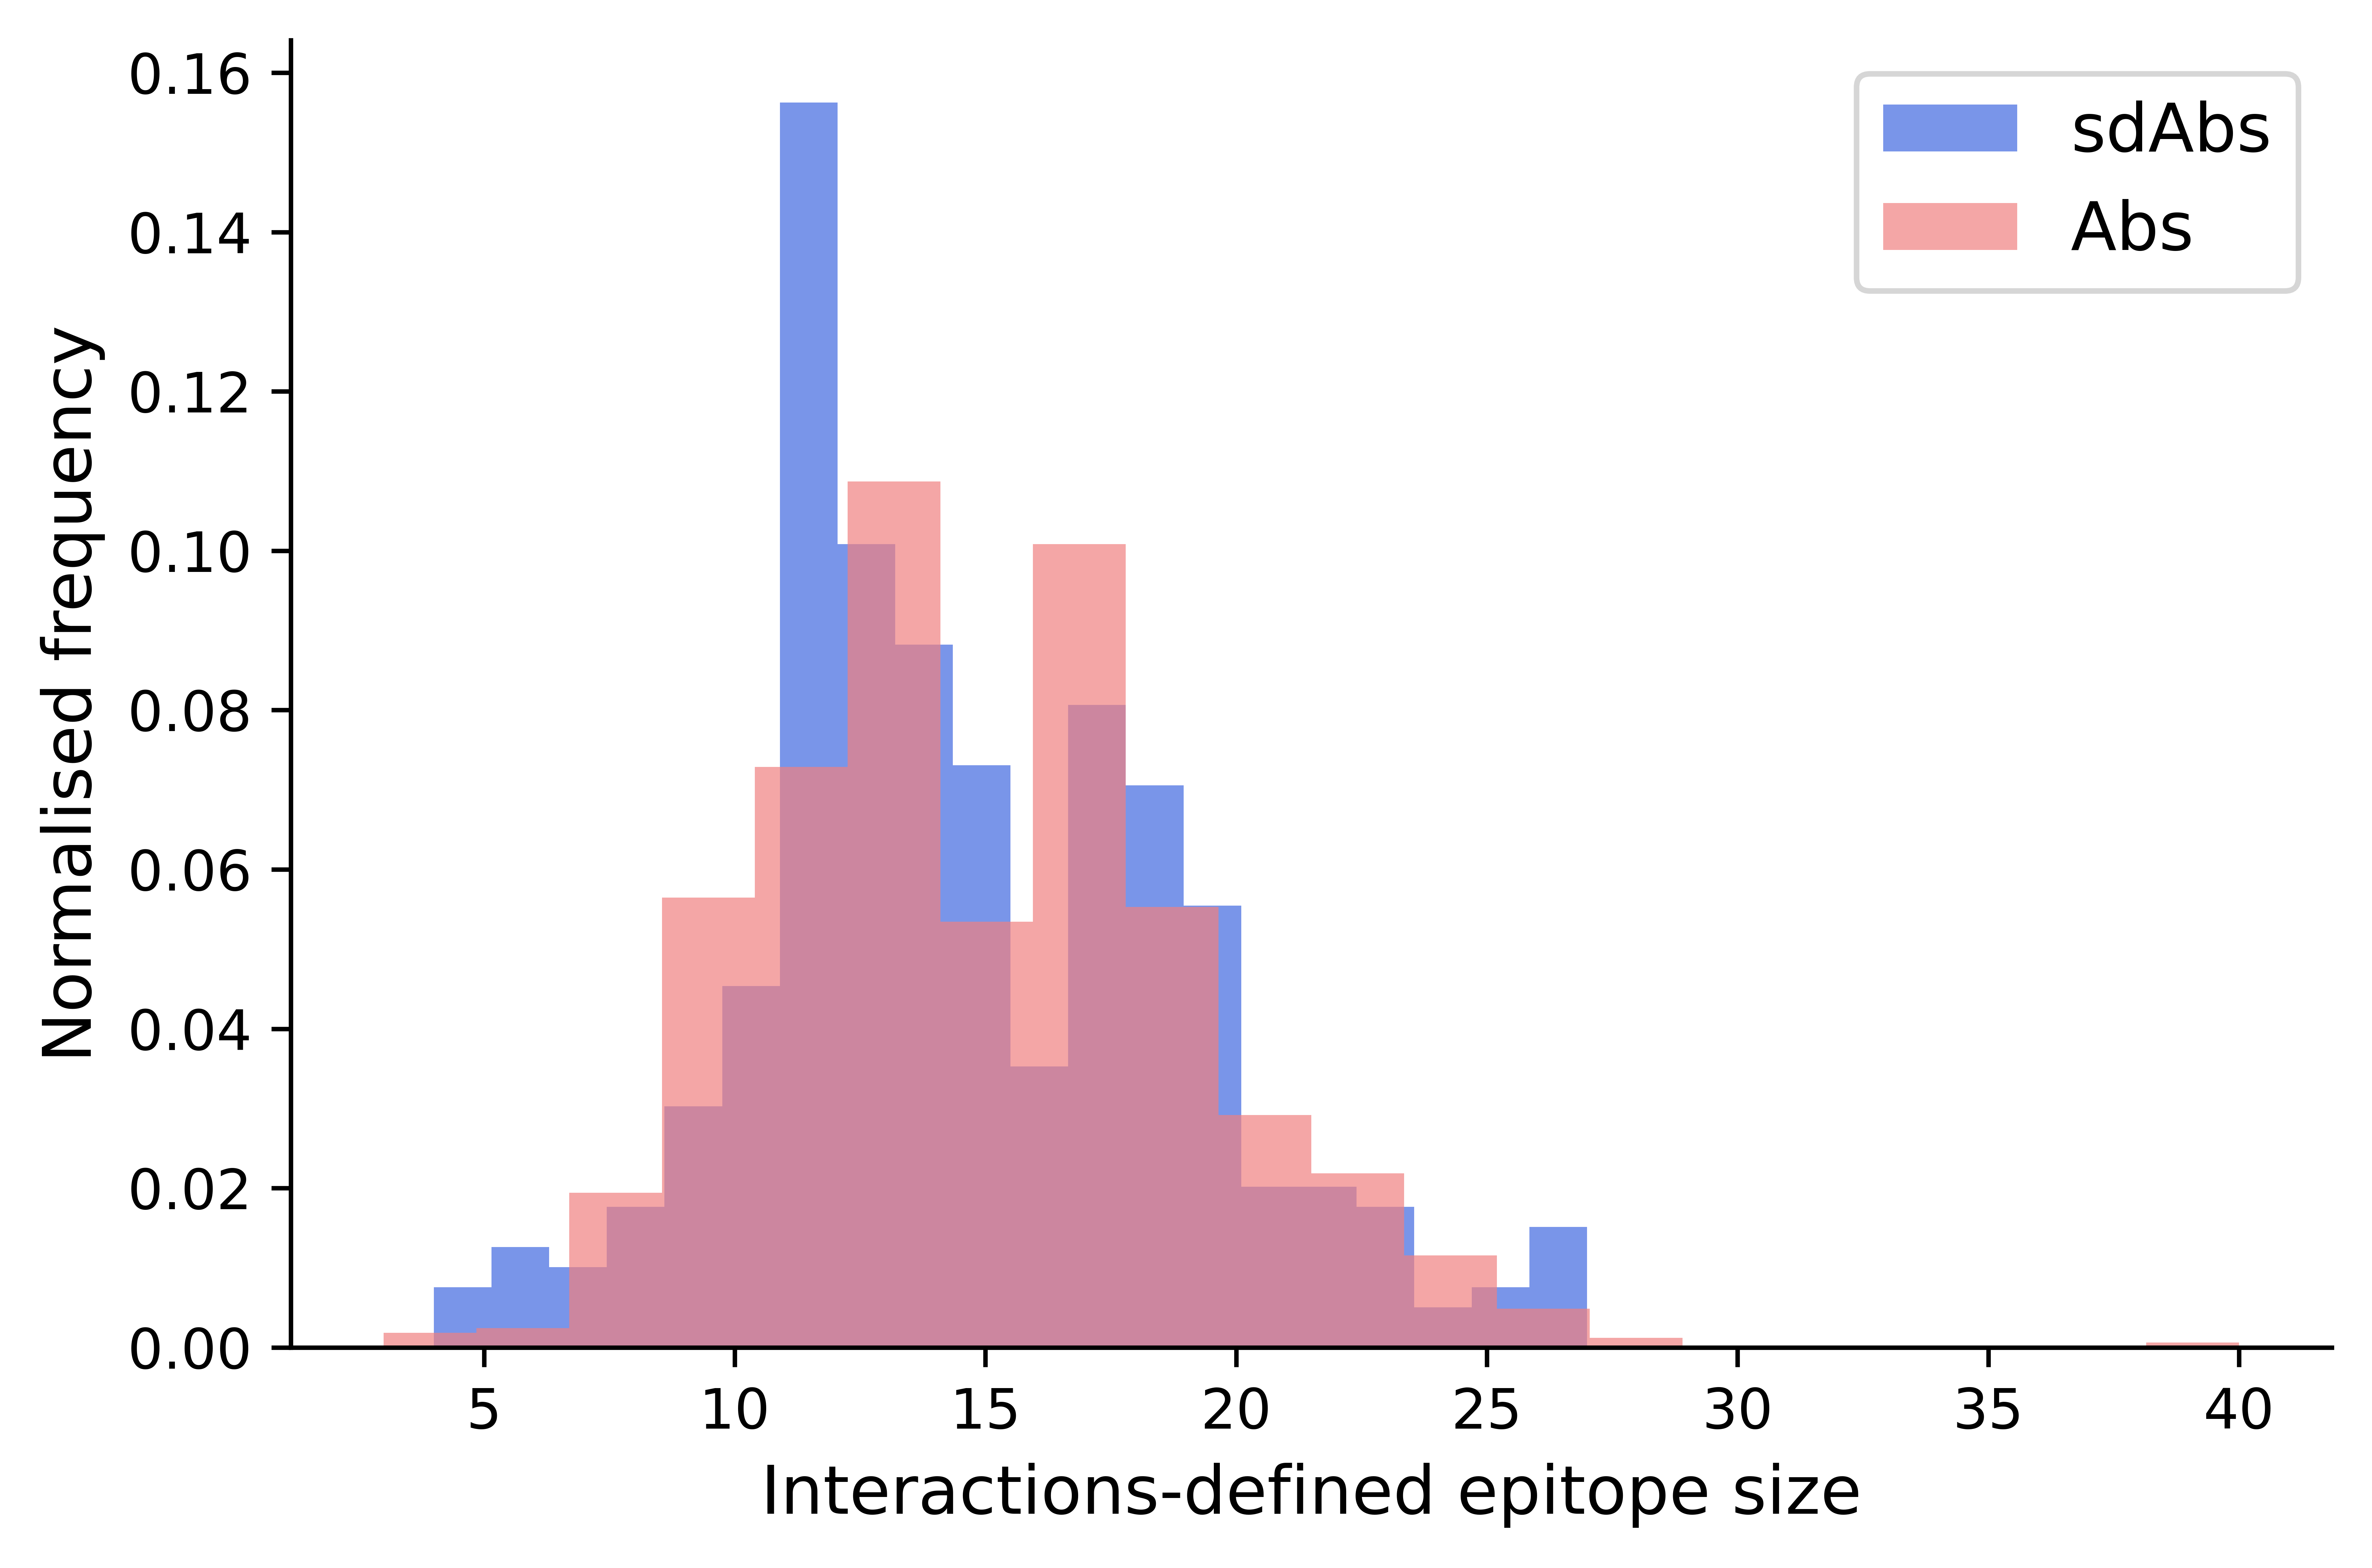

In [11]:
#Plot epitope length
plot_interaction_length(df_lengths_arp_nb['epitope_length'], df_lengths_arp_fv['epitope_length'], 'Interactions-defined epitope', 'sdAbs', 'Abs', 'royalblue', 'lightcoral', bins = 20)
ztest(df_lengths_arp_nb["epitope_length"], df_lengths_arp_fv["epitope_length"]) 
perform_bootstrap(300, {'sdab': df_lengths_arp_nb["epitope_length"], 'flab': df_lengths_arp_fv["epitope_length"]})


DABEST v0.3.1
             
Good afternoon!
The current time is Wed Mar 29 17:14:43 2023.

The unpaired mean difference between sdab and flab_VH is -3.17 [95%CI -3.74, -2.63].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


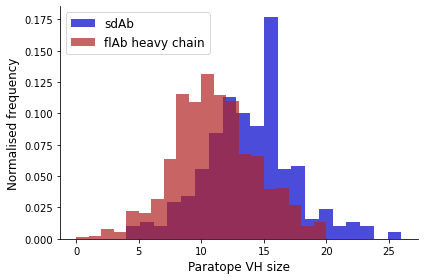

In [13]:
#Plot paratope (heavy chain length)
plot_interaction_length(df_lengths_arp_nb['paratope_length'], df_lengths_arp_fv['paratope_heavy_length'], 'Paratope VH', 'sdAb', 'flAb heavy chain', 'mediumblue', 'firebrick')
ztest(df_lengths_arp_nb["paratope_length"].to_numpy(), df_lengths_arp_fv["paratope_heavy_length"].to_numpy(), value=0) 
perform_bootstrap(300, {'sdab': df_lengths_arp_nb["paratope_length"], 'flab_VH': df_lengths_arp_fv["paratope_heavy_length"]})


DABEST v0.3.1
             
Good morning!
The current time is Mon May 22 11:20:56 2023.

The unpaired mean difference between sdab and flab is 2.57 [95%CI 1.99, 3.17].
The p-value of the two-sided permutation t-test is 0.0. 

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.
For each p-value, 5000 reshuffles of the control and test labels were performed.

To get the results of all valid statistical tests, use `.mean_diff.statistical_tests`


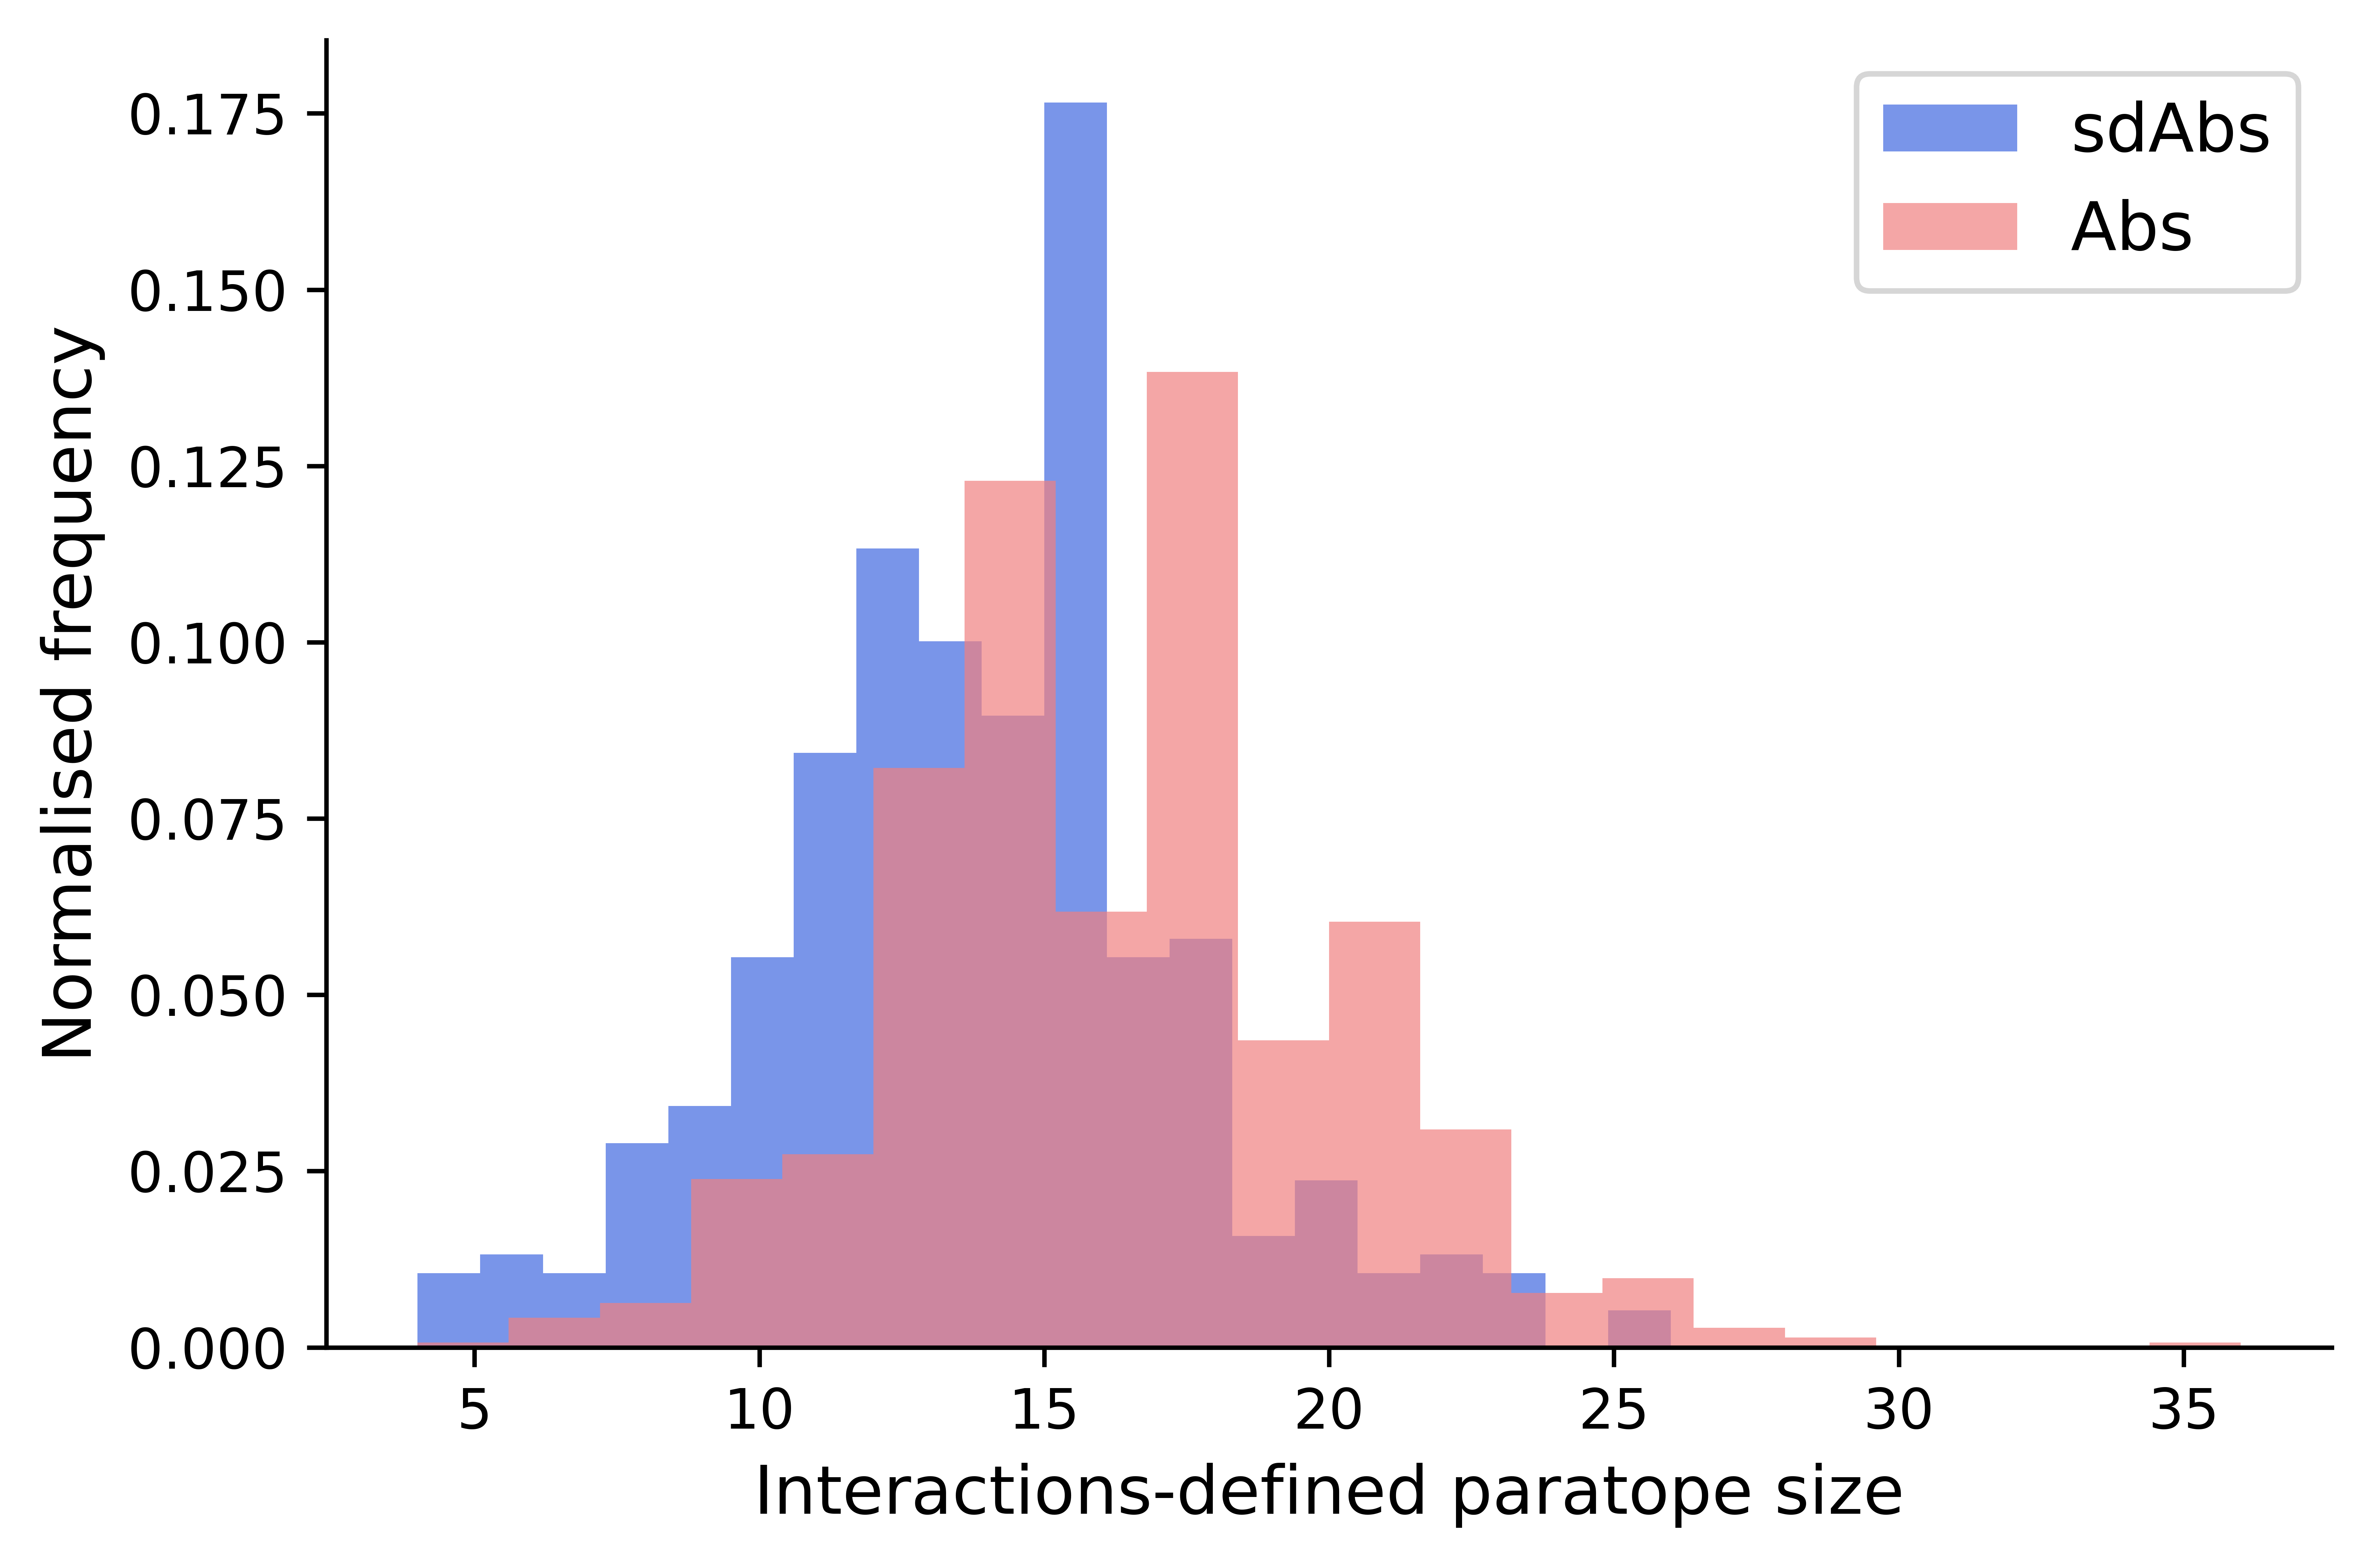

In [12]:
#Plot paratope length, for full length both heavy and light combined
plot_interaction_length(df_lengths_arp_nb['paratope_length'], df_lengths_arp_fv['paratope_length'], 'Interactions-defined paratope', 'sdAbs', 'Abs', 'royalblue', 'lightcoral')
ztest(df_lengths_arp_nb["paratope_length"].to_numpy(), df_lengths_arp_fv["paratope_length"].to_numpy(), value=0) 
perform_bootstrap(300, {'sdab': df_lengths_arp_nb["paratope_length"], 'flab': df_lengths_arp_fv["paratope_length"]})
